In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import zipfile
import os
import datetime
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [3]:
residencies = [str(x) for x in range(1,7)]
env_columns = ['tvoc_ppb', 'temp_c', 'rh_percent', 'light_lux', 'co2eq_ppm', 'co2eq_base', 'tvoc_base', 'hub', 'home']

In [2]:
# for residency in residencies:
#     with zipfile.ZipFile(f'C://Users/ermin.omeragic/Downloads/H{residency}_AUDIO.zip') as zf:
#         for member in tqdm(zf.infolist(), desc='Extracting '):
#             try:
#                 zf.extract(member, f'C://Users/ermin.omeragic/Desktop/EnOcean/SmartBuildingsDataExploration/data/HPDMobile/Residency 0{residency}/H{residency}_AUDIO/')
#             except zipfile.error as e:
#                 pass

Extracting : 100%|██████████| 591967/591967 [08:19<00:00, 1184.76it/s]


In [9]:
for residency in residencies:
    directory = f'../../data/HPDMobile/Household 0{residency}/H{residency}_ENVIRONMENTAL/'
    residency_df = pd.DataFrame(columns=env_columns)
    gt_files = os.listdir(f'../../data/HPDMobile/Household 0{residency}/H{residency}_GROUNDTRUTH/')
    file_names = sorted([os.path.join(folder_name, file_name) for folder_name in os.listdir(directory) for file_name in os.listdir(os.path.join(directory, folder_name))], key=lambda x: datetime.datetime.strptime(x.split('\\')[1].split('_')[0], '%Y-%m-%d'))
    for file_name in file_names:
        env_file = pd.read_csv(os.path.join(directory, file_name), header=0, index_col=0)
        date = file_name.split('\\')[-1].split('_')[0]
        gt_file_name = [file for file in gt_files if file[:10]==date][0]
        gt_file = pd.read_csv(f'../../data/HPDMobile/Household 0{residency}/H{residency}_GROUNDTRUTH/{gt_file_name}', header=0, index_col=0)
        env_file['occupied'] = gt_file['occupied']
        env_file = env_file.dropna()
        day_df = env_file.sort_index()
        residency_df = pd.concat([residency_df, env_file])
    residency_df = residency_df.sort_index()
    residency_df.to_csv(f'../../data/HPDMobile/Household 0{residency}/combined.csv')

# Downsampling

In [ ]:
def convert_timestamp_to_datetime(timestamp_string):
    return datetime.datetime.strptime(timestamp_string, "%Y-%m-%d %H:%M:%S")

for residency in residencies:
    csv1 = pd.read_csv(f'../../data/HPDMobile/Household 0{residency}/combined.csv', parse_dates=[0], index_col=0, date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    resampled = csv1.groupby(['home', 'hub']).resample('1T', how='mean').mean().reset_index()
    resampled = resampled.rename(columns={'level_0': 'Household', 'level_1': 'Hub', 'level_2': 'Timestamp'}).set_index('Timestamp', drop=True)
    resampled = resampled.dropna()
    resampled.to_csv(f'../../data/HPDMobile/Household 0{residency}/combined.csv')

In [16]:
csv1 = pd.read_csv('../../data/HPDMobile/Household 01/combined.csv')
csv1['Household'] = 'Household 01'
csv2 = pd.read_csv('../../data/HPDMobile/Household 02/combined.csv')
csv2['Household'] = 'Household 02'
csv3 = pd.read_csv('../../data/HPDMobile/Household 03/combined.csv')
csv3['Household'] = 'Household 03'
csv4 = pd.read_csv('../../data/HPDMobile/Household 04/combined.csv')
csv4['Household'] = 'Household 04'
csv5 = pd.read_csv('../../data/HPDMobile/Household 05/combined.csv')
csv5['Household'] = 'Household 05'
csv6 = pd.read_csv('../../data/HPDMobile/Household 06/combined.csv')
csv6['Household'] = 'Household 06'

In [19]:
total_csv = pd.concat([csv1, csv2, csv3, csv4, csv5, csv6], sort=False)
total_csv = total_csv.sort_values(by=['Timestamp', 'Household'])

total_csv.to_csv('../../data/HPDMobile/combined.csv', index=False)

# Audio files processing

In [2]:
data_path = '../../data/HPDMobile'
households = ['Household 01', 'Household 02', 'Household 03', 'Household 04', 'Household 05', 'Household 06']
audio_folder_names = ['H1_AUDIO', 'H2_AUDIO', 'H3_AUDIO', 'H4_AUDIO', 'H5_AUDIO', 'H6_AUDIO']
amount_of_sensors = 5

In [3]:
import librosa
import librosa.display
import warnings

sr = 80
total_len = 5313908-1979735
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with tqdm(total=total_len, desc='Melspectrogram extracting',
                  unit='chunks') as prog_bar:
        for household, audio_folder_name in zip(households[2:], audio_folder_names[2:]):
            folder_path = os.path.join(data_path, household, audio_folder_name)
            sensor_device_folders = os.listdir(folder_path)
            for device in sensor_device_folders:
                if device == '.DS_Store':
                        continue
                day_folders = os.listdir(os.path.join(data_path, household, audio_folder_name, device))
                for day in day_folders:
                    if day == '.DS_Store':
                        continue
                    minute_folders = os.listdir(os.path.join(data_path, household, audio_folder_name, device, day))
                    for minute in minute_folders:
                        if minute == '.DS_Store':
                            continue
                        file_path = os.path.join(data_path, household, audio_folder_name, device, day, minute)
                        files = os.listdir(file_path)
                        minute_audio = np.array([])
                        for file in [file for file in files if file[-4:]!='.npy']:
                            try:
                                ten_second_audio = np.loadtxt(os.path.join(file_path, file), delimiter=",")
                                minute_audio = np.append(arr=minute_audio, values=ten_second_audio)
                            except UnicodeDecodeError:
                                continue
                        if len(minute_audio) < sr*60:
                            minute_audio = np.append(minute_audio, np.zeros(sr*60-len(minute_audio)))
                        elif len(minute_audio) > sr*60:
                            minute_audio = minute_audio[:sr*60]
                        mel_spec = librosa.feature.melspectrogram(y=minute_audio, sr=sr, n_mels=64)
                        S_dB = librosa.power_to_db(mel_spec, ref=np.max)
                        with open(os.path.join(file_path, f'{household}-{device}-{day}-{minute}.npy'), 'wb') as f:
                            np.save(f, S_dB)
                        prog_bar.set_postfix(**{'Household:': household, 'device': device,
                                        'day': day, 'minute': minute
                                        })
                        prog_bar.update(len(files))

Melspectrogram extracting: 3544536chunks [2:36:28, 377.52chunks/s, Household:=Household 06, day=2019-12-05, device=H6_BS5_AUDIO, minute=2359]                           


# Preprocessing

In [13]:
total_csv = pd.read_csv('../../data/HPDMobile/combined.csv')

In [15]:
total_csv.loc[total_csv['rh_percent']>100, 'rh_percent'] = np.nan
total_csv.loc[total_csv['co2eq_ppm']>20000, 'co2eq_ppm'] = np.nan
# Impute the NaN Values:
print('Current number of NaN rows before imputing: ', total_csv.isna().sum().sum())
imputer = KNNImputer(n_neighbors=4, weights="uniform")
filtered = imputer.fit_transform(total_csv.select_dtypes(['number']))
total_csv[total_csv.select_dtypes(['number']).columns] = filtered
print('Current number of NaN rows after imputing: ', total_csv.isna().sum().sum())

Current number of NaN rows before imputing:  160
Current number of NaN rows after imputing:  0


In [16]:
mask = (total_csv['Household']=='Household 01') | (total_csv['Household']=='Household 02') | (total_csv['Household']=='Household 03')
train_df = total_csv[mask]
test_df = total_csv[-mask]

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardize temperature levels
v1_scaler = StandardScaler().fit(train_df['temp_c'].to_numpy().reshape(-1, 1))
total_csv['temp_c'] = v1_scaler.transform(total_csv['temp_c'].to_numpy().reshape(-1, 1))

# Standardize Co2 base values
v1_scaler = StandardScaler().fit(train_df['co2eq_base'].to_numpy().reshape(-1, 1))
total_csv['co2eq_base'] = v1_scaler.transform(total_csv['co2eq_base'].to_numpy().reshape(-1, 1))

# Log-transform the Co2 Ppm
total_csv['co2eq_ppm'] = np.log(total_csv['co2eq_ppm'] - 399)

# Log transform the Light lux
total_csv['light_lux'] = np.log(total_csv['light_lux'] + 1)

# Min-Max scale relative humidity
v1_scaler = MinMaxScaler().fit(train_df['rh_percent'].to_numpy().reshape(-1, 1))
total_csv['rh_percent'] = v1_scaler.transform(total_csv['rh_percent'].to_numpy().reshape(-1, 1))

# Standardize Tvoc base values
v1_scaler = StandardScaler().fit(train_df['tvoc_base'].to_numpy().reshape(-1, 1))
total_csv['tvoc_base'] = v1_scaler.transform(total_csv['tvoc_base'].to_numpy().reshape(-1, 1))

# Log transform the Light lux
total_csv['tvoc_ppb'] = np.log(total_csv['tvoc_ppb'] + 1)

In [18]:
def convert_timestamp_to_datetime(timestamp_string):
    return datetime.datetime.strptime(timestamp_string, "%Y-%m-%d %H:%M:%S")

total_csv['Timestamp'] = total_csv['Timestamp'].apply(convert_timestamp_to_datetime)
total_csv['Hour'] = total_csv['Timestamp'].apply(lambda x: x.hour)

one_hot = pd.get_dummies(total_csv['Hour'])
total_csv.drop('Hour', axis=1, inplace=True)
total_csv = pd.concat([total_csv, one_hot], axis=1)

In [26]:
total_csv.loc[total_csv['occupied']<0.5, 'occupied'] = 0
total_csv.loc[total_csv['occupied']>=0.5, 'occupied'] = 1

total_csv.to_csv('../../data/HPDMobile/combined_cleaned.csv', index=False)

### Creating column 'days since start of measurements' for easier sampling

In [10]:
total_csv = pd.read_csv('../../data/HPDMobile/combined_cleaned.csv')
total_csv['Timestamp'] = pd.to_datetime(total_csv['Timestamp'])
households = ['Household 01', 'Household 02', 'Household 03', 'Household 04', 'Household 05', 'Household 06']
total_csv['DaysSinceStart'] = 0
for household in households:
    subset_df = total_csv.loc[total_csv['Household']==household, :]
    starting_date = subset_df.iloc[0, 0]
    total_csv.loc[total_csv['Household']==household, 'DaysSinceStart'] = (subset_df['Timestamp'] - starting_date).dt.days

total_csv.to_csv('../../data/HPDMobile/combined_cleaned.csv', index=False)

### Adding 15 and 30 minute occupancy information

In [3]:
total_csv = pd.read_csv('../../data/HPDMobile/combined_cleaned.csv')
def convert_timestamp_to_datetime(timestamp_string):
    return datetime.datetime.strptime(timestamp_string, "%Y-%m-%d %H:%M:%S")
total_csv['Timestamp'] = total_csv['Timestamp'].apply(convert_timestamp_to_datetime)
total_csv['Occupancy15Min'] = 0
total_csv['Occupancy30Min'] = 0

for household in ['Household 01', 'Household 02', 'Household 03', 'Household 04', 'Household 05']:
    for rs in ['RS1', 'RS2', 'RS3', 'RS4', 'RS5']:
        room_df = total_csv.loc[(total_csv['Household'] == household) & (total_csv['hub'] == rs), :]
        lagged_15 = room_df['occupied'].shift(-15)
        difference_15 = -room_df['Timestamp'].diff(periods=-15)
        indices_15 = difference_15 != datetime.timedelta(minutes=15)
        lagged_15[indices_15] = -1
        total_csv.loc[(total_csv['Household'] == household) & (total_csv['hub'] == rs), 'Occupancy15Min'] = lagged_15

        lagged_30 = room_df['occupied'].shift(-30)
        difference_30 = -room_df['Timestamp'].diff(periods=-30)
        indices_30 = difference_30 != datetime.timedelta(minutes=30)
        lagged_30[indices_30] = -1
        total_csv.loc[(total_csv['Household'] == household) & (total_csv['hub'] == rs), 'Occupancy30Min'] = lagged_30

total_csv.to_csv('../../data/HPDMobile/combined_cleaned.csv')

# Correlation plots and feature scoring

Text(0.5, 1.0, 'Correlation Matrix')

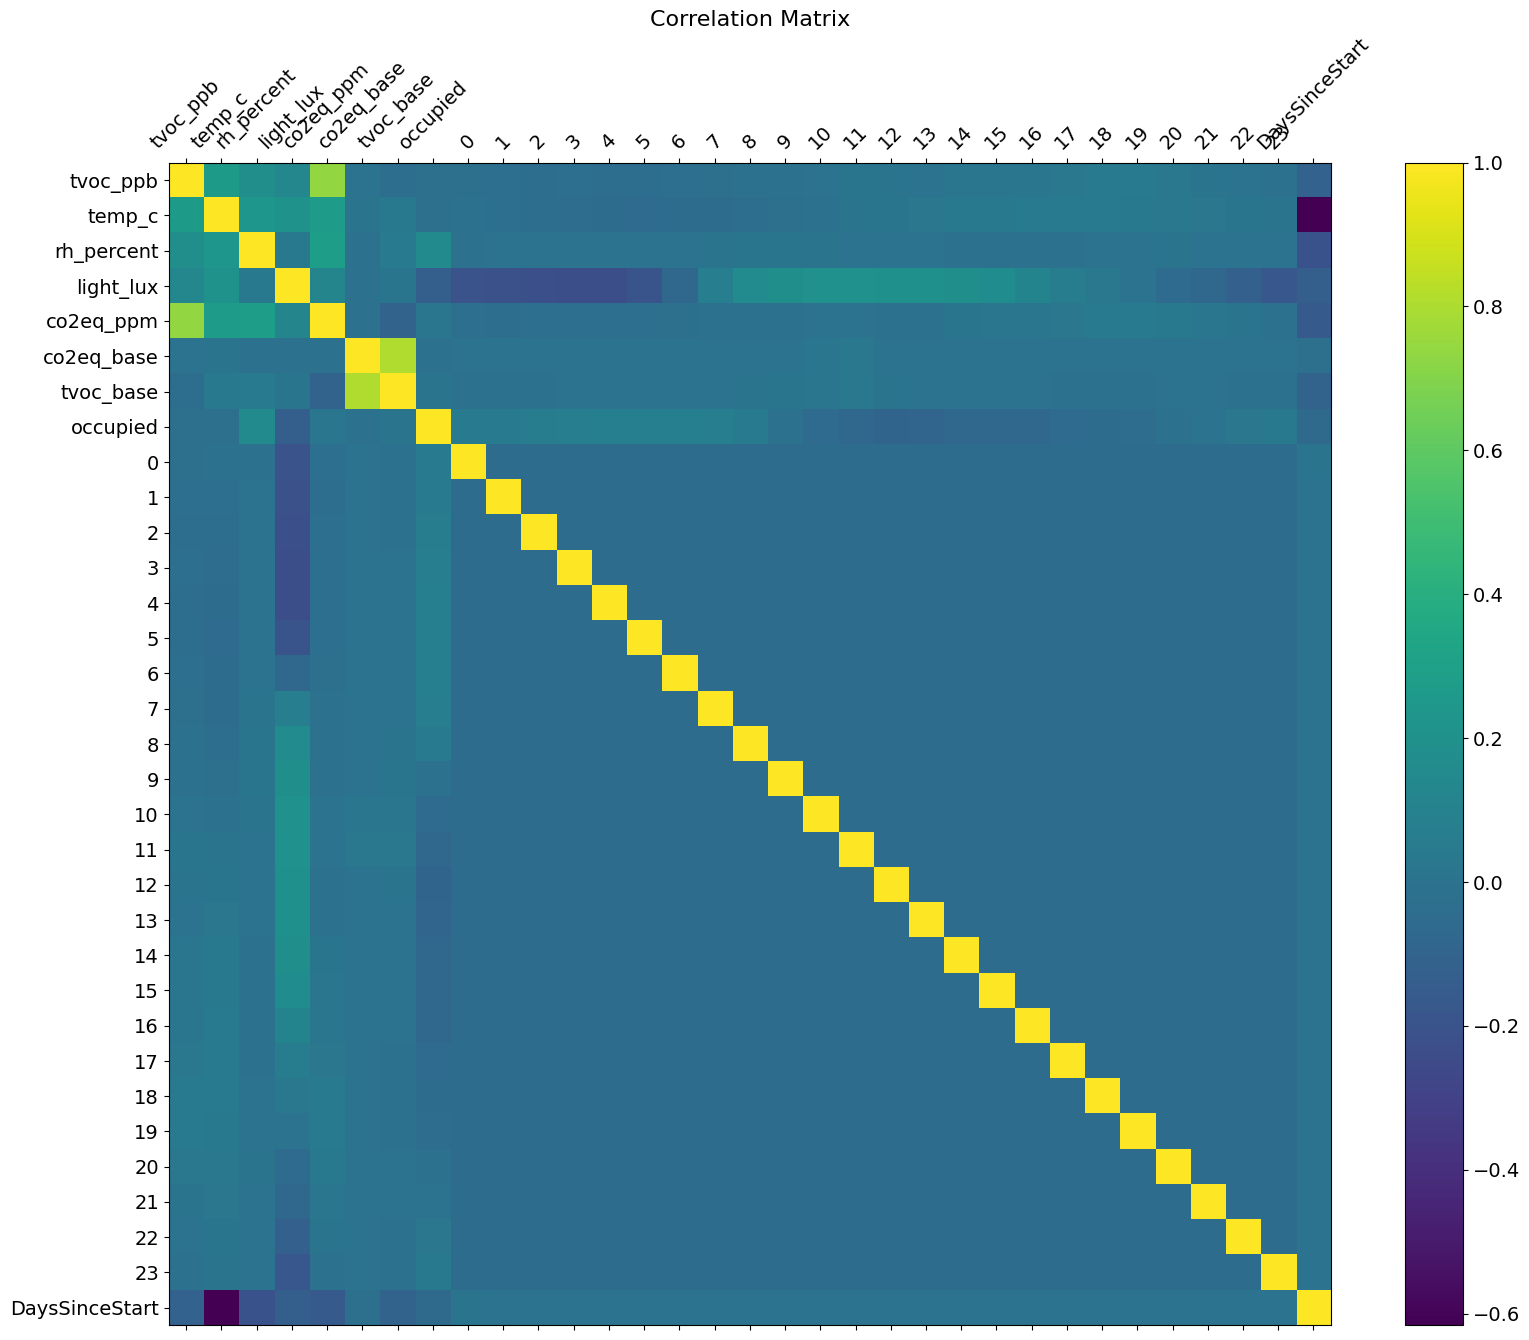

In [5]:
f = plt.figure(figsize=(19, 15))
plt.matshow(total_csv.select_dtypes(['number']).corr(), fignum=f.number)
plt.xticks(range(total_csv.select_dtypes(['number']).shape[1]), total_csv.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(total_csv.select_dtypes(['number']).shape[1]), total_csv.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [30]:
train_df = total_csv[mask].drop(['home', 'hub', 'Household', 'Timestamp'], axis=1)

Feature: tvoc_ppb, Score: 0.01834
Feature: temp_c, Score: 0.02279
Feature: rh_percent, Score: 0.02052
Feature: light_lux, Score: 0.02199
Feature: co2eq_ppm, Score: 0.01644
Feature: co2eq_base, Score: 0.01279
Feature: tvoc_base, Score: 0.02158
Feature: 0, Score: 0.01732
Feature: 1, Score: 0.02100
Feature: 2, Score: 0.02595
Feature: 3, Score: 0.04234
Feature: 4, Score: 0.05219
Feature: 5, Score: 0.05925
Feature: 6, Score: 0.06893
Feature: 7, Score: 0.06958
Feature: 8, Score: 0.06389
Feature: 9, Score: 0.02324
Feature: 10, Score: 0.01460
Feature: 11, Score: 0.02029
Feature: 12, Score: 0.04416
Feature: 13, Score: 0.04819
Feature: 14, Score: 0.02406
Feature: 15, Score: 0.03304
Feature: 16, Score: 0.03611
Feature: 17, Score: 0.04651
Feature: 18, Score: 0.02988
Feature: 19, Score: 0.02597
Feature: 20, Score: 0.03157
Feature: 21, Score: 0.02738
Feature: 22, Score: 0.02420
Feature: 23, Score: 0.01588


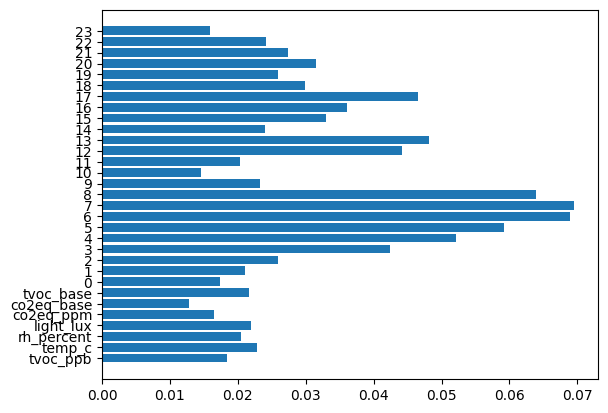

In [31]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
# define dataset
y = train_df['occupied']
X = train_df.loc[:, train_df.columns != 'occupied']
#X.columns = [s.translate({ord(i): None for i in '[]<'}) for s in X.columns]
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for (i,v), names in zip(enumerate(importance), X.columns):
 print(f'Feature: {names}, Score: {v:.5f}')
# plot feature importance
plt.barh([x for x in range(len(importance))], importance)
plt.yticks(ticks=range(0,len(X.columns)), labels=X.columns)
plt.show()